<a href="https://colab.research.google.com/github/bergsteve/stock-return/blob/master/solution_copied_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-06-29 11:24:07--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2020-06-29 11:24:08 (8.39 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



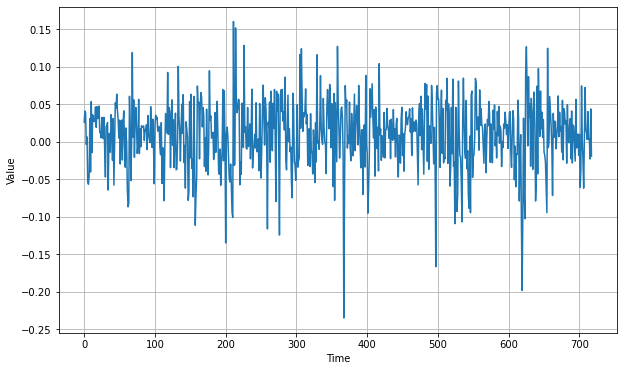

In [ ]:
url = 'https://raw.githubusercontent.com/bergsteve/stock-return/master/data_complete.csv'
df = pd.read_csv(url)
df = df.sort_values(by='date')


temps = time_data = df["return"]
time_step = df["index"]
time = np.arange(718)
series = np.array(temps)

#time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

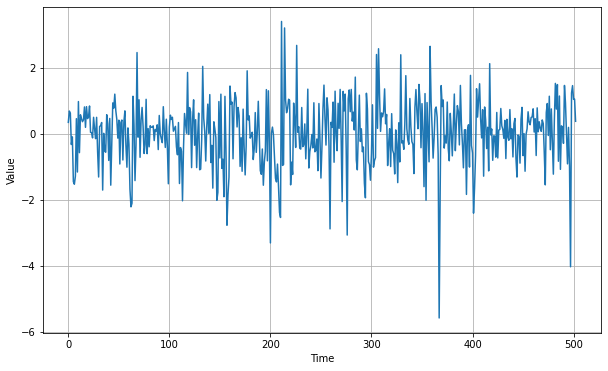

In [60]:
split_time = 503
split_time_1 = 646
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

x_valid = x_valid[:143]
# standardizing the training data
x_train_mean = x_train.mean()
x_train_std = x_train.std()


x_train = (x_train-x_train_mean)/x_train_std

# creating new series without test data
series_1 = series[:split_time_1]
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=7,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

In [61]:
rnn_forecast = model_forecast(model, series_1[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

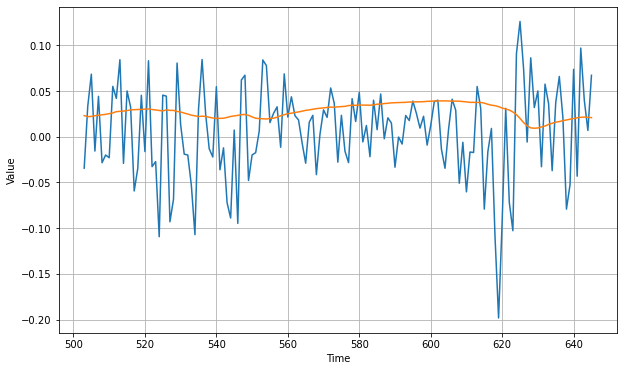

In [63]:
time_valid_plot = np.arange(503,646)
plt.figure(figsize=(10, 6))
plot_series(time_valid_plot, x_valid)
plot_series(time_valid_plot, rnn_forecast)


In [64]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.044196643

In [ ]:
print(rnn_forecast)

In [ ]:
split_time_1 = 503
split_time_2 = 646
time_valid = time[split_time_1:split_time_2]
x_valid = series[split_time_1:split_time_2]
time_valid = time[split_time:]
x_valid = series[split_time:]

x_train_mean = x_train.mean()
x_train_std = x_train.std()

x_train = (x_train-x_train_mean)/x_train_std

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

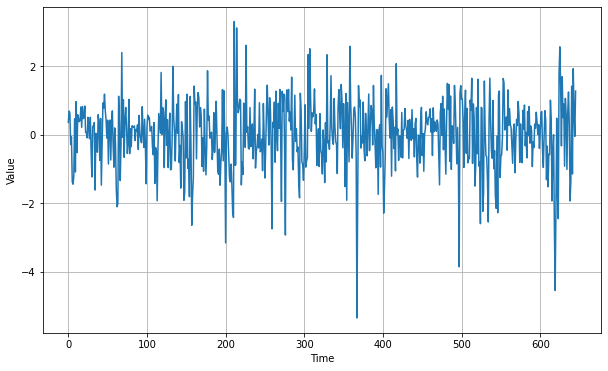

In [ ]:
# Defining train+val data and testing data

split_train = 646

x_train_new = series[:split_train]
x_test = series[split_train:]


time_train_new = time[:split_train]
time_test = time[split_train:]

x_train_new_mean = x_train_new.mean()
x_train_new_std = x_train_new.std()

x_train_new = (x_train_new-x_train_new_mean)/x_train_new_std

plt.figure(figsize=(10, 6))
plot_series(time_train_new, x_train_new)




In [ ]:
# now calculating model with train # val data and compare with test data




In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train_new, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
print(train_set)
print(x_train_new.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


(1e-08, 0.0001, 0.0, 60.0)

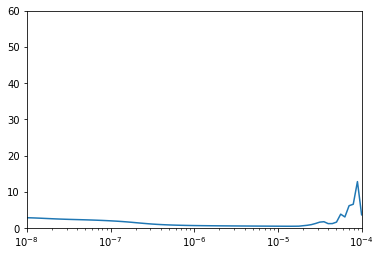

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train_new, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=7,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
6/6 [==============================] - 0s 11ms/step - loss: 1.8857 - mae: 2.3404
Epoch 2/150
6/6 [==============================] - 0s 9ms/step - loss: 1.1120 - mae: 1.5450
Epoch 3/150
6/6 [==============================] - 0s 9ms/step - loss: 0.6411 - mae: 1.0376
Epoch 4/150
6/6 [==============================] - 0s 9ms/step - loss: 0.4964 - mae: 0.8770
Epoch 5/150
6/6 [==============================] - 0s 10ms/step - loss: 0.4505 - mae: 0.8255
Epoch 6/150
6/6 [==============================] - 0s 9ms/step - loss: 0.4198 - mae: 0.7873
Epoch 7/150
6/6 [==============================] - 0s 10ms/step - loss: 0.4045 - mae: 0.7686
Epoch 8/150
6/6 [==============================] - 0s 10ms/step - loss: 0.3992 - mae: 0.7622
Epoch 9/150
6/6 [==============================] - 0s 9ms/step - loss: 0.3953 - mae: 0.7583
Epoch 10/150
6/6 [==============================] - 0s 9ms/step - loss: 0.3924 - mae: 0.7552
Epoch 11/150
6/6 [==============================] - 0s 9ms/step - loss: 0.3

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_train - window_size:-1, -1, 0]

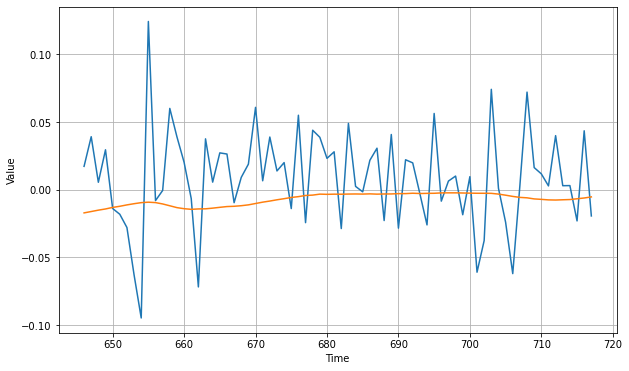

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_test, x_test)
plot_series(time_test, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_test, rnn_forecast).numpy()

0.031442568